# Transformer의 multi head attention을 구현해보자

In [1]:
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader

$h$ = 8

$d_{model}$ : 512  
$d_e$ : embedding size  논문에서는 $d_{model}$로서 input , output을 유지하려고 함
$d_k = d_q$ : 64  
$d_v$ : 64  
output : $d_o$ : 512
$d_{ff}$ : 2048

In [2]:
h=8
n = 6
d_model = 512
dv = 64
dk= d_model//h
dff = 2048
do = dv*h
T = 100 #input sequence size
print(dv, dk)

64 64


# Dimension
CV에서 Image가 (batch, channel, width, height) 4 dimension인것과 다르게   
nlp에서 data는 (batch, seq_len , embedding_dimmension)을 가진다  
이를 번역 task 기준으로 생각해보면 한 문장을 1 batch라고 할 때  
batch  : 문장의 갯수   
seq_len: 문장의 길이   
embedding_dim: 각 단어(Token)의 embedding (ex positional embedding, embedding, one-hot encodding) 

In [3]:
#한개의 batch에 대해서 test
data = torch.randn(T,d_model)  # row: sample, column : embedding
#embedding되었다고 가정 
data.shape

torch.Size([100, 512])

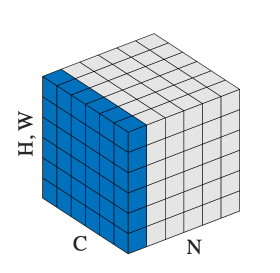
# Layer normalization NLP Example
```python
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim)
layer_norm(embedding)

```

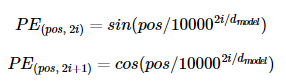  
pos: 입력 문장에서의 임베딩 벡터의 위치를 나타낸다  
i: 임베딩 벡터 내의 차원 인덱스 
```python
pos = torch.arange(0,T,dtype =torch.float32).view(-1,1) # embedding row
i   = torch.arange(0,d_model,dtype = torch.float32).view(1,-1) # embedding col
def get_angles(pos, i, d_model,n=10000): #position, i, d_model
    return pos / n**((2*i)/d_model)
PE(pos,2i)  : torch.sin(get_angles(pos, i, d_model,n))
PE(pos,2i+1): torch.cos(get_angles(pos, i, d_model,n)) 
```


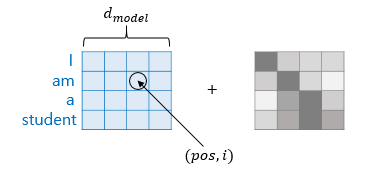\\    
[참고1](https://gaussian37.github.io/dl-concept-positional_encoding/)

[참고2](https://wikidocs.net/31379) 여기 positional encoding 구현 잘못됨


In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self,T,d_model,n=10000):
        super(PositionalEncoding,self).__init__()
        # self.pos_encoding = self.positional_encoding(position,d_mode)
        
        #create embedding matrix
        self.encoding = torch.zeros(T,d_model)
        
        # create index 
        pos = torch.arange(0,T,dtype =torch.float32).view(-1,1) # embedding row
        i   = torch.arange(0,d_model,step=2,dtype = torch.float32).view(1,-1) # embedding col
        # sin, cos가 같은 i를 사용하므로, i=d_model/2
        self.encoding[:, ::2] =  torch.sin(self.get_angles(pos, i, d_model,n)) #홀수 부분만 
        self.encoding[:, 1::2] = torch.cos(self.get_angles(pos, i, d_model,n)) # 짝수 부분만
        
    def get_angles(self, pos, i, d_model,n): #position, i, d_model
        return pos / n**((2*i)/d_model)
   

    def forward(self,x):
        T = x.shape[0] # batch_size가 없을 때 기준 
        # T = x.shape[1] # batch_size가 있으면 T =
        return self.encoding[:T,:] 
        #self.encoding[:T,:]에서 :T indexing을 해주는 이유는 Seq가 일정하지 않을 수 있기 때문인듯 
        #padding을 하지 않더라도 동작할 수 있게끔 indexing을 해주는듯 하다 

In [5]:
pos_encoding = PositionalEncoding(T=T, d_model=d_model)

In [6]:
import matplotlib.pyplot as plt

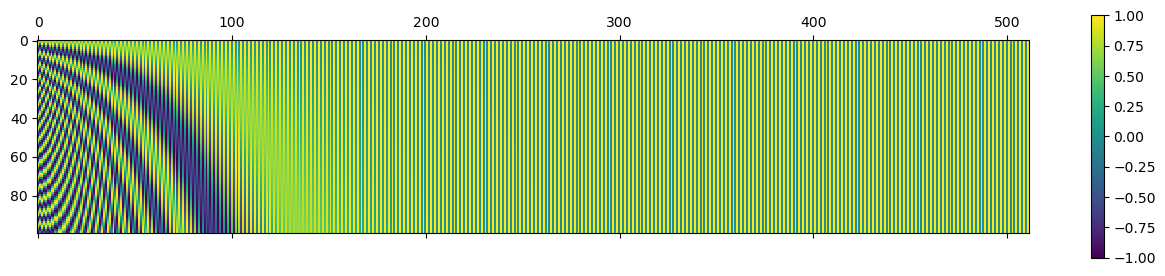

In [7]:
encoding = plt.matshow(pos_encoding(data))
plt.gcf().colorbar(encoding) #gcf는 get current figure의 약자
# plt.gcf() 함수와 비슷한 함수로는 plt.gca(), 이것은 현재 Axes 객체를 반환한다.
plt.show()

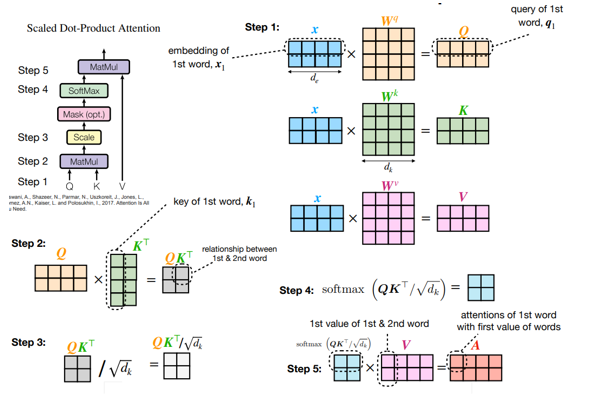

$W^Q_i\in \mathbb{R}^{d_{model}\; \times d_k}$  
$W^K_i\in \mathbb{R}^{d_{model}\; \times d_k}$  
$W^V_i\in \mathbb{R}^{d_{model}\; \times d_v}$  

In [8]:
#
wq = nn.Linear(d_model,dk,bias = False)
wk = nn.Linear(d_model,dk,bias = False)
wv = nn.Linear(d_model,dv,bias = False)
Q = wq(data)
K = wk(data)
V = wv(data)
print(Q.shape, K.shape, V.shape)

torch.Size([100, 64]) torch.Size([100, 64]) torch.Size([100, 64])


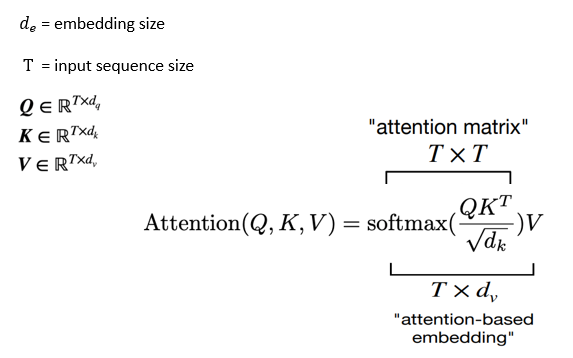

In [9]:
sqrt_dk = torch.sqrt(torch.tensor(dk,dtype = torch.float32)) 
score = Q@K.T
scaling = score/sqrt_dk
distribution = torch.nn.Softmax(dim=0)(scaling) # Softmax는 T를 기준으로 해야함

# self attention 구현

In [10]:
def self_attention(d_model,dv,dk,x)->"n x dk": 
    """
    return one-head attention matrix, 
    calculate self-attention and attention matrix 
    attention matrix size : Sample_num x dk 
    """
    wq = nn.Linear(d_model,dk,bias = False)
    wk = nn.Linear(d_model,dk,bias = False)
    wv = nn.Linear(d_model,dv,bias = False)
    #self-Q,K,V
    Q = wq(x)
    K = wk(x)
    V = wv(x)
    ## attention
    sqrt_dk = torch.sqrt(torch.tensor(dk,dtype = torch.float32)) 
    score = Q@K.T
    scaling = score/sqrt_dk
    distribution = torch.nn.Softmax(dim=0)(scaling) # Softmax는 T를 기준으로 해야함
    return distribution@V

In [11]:
one_head = self_attention(d_model,dv, dk,data)
one_head.shape

torch.Size([100, 64])

# multi head로 구현

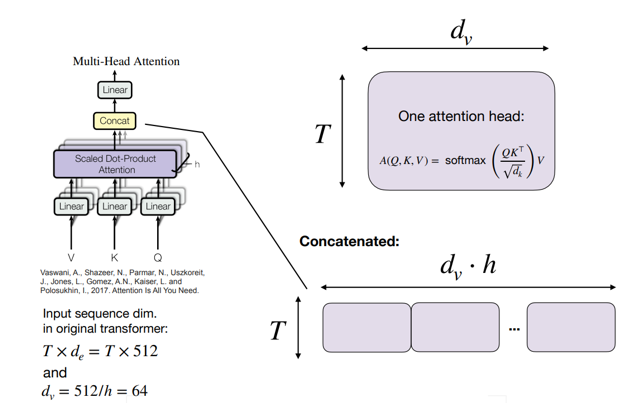

In [12]:
A = []
for i in range(h):
    head = self_attention(d_model,dv, dk,data)
    A.append(head)

In [13]:
A[0].shape , len(A)

(torch.Size([100, 64]), 8)

In [14]:
torch.cat(A,dim=1).shape # T : 100, d_v * h = 64*8 =512

torch.Size([100, 512])

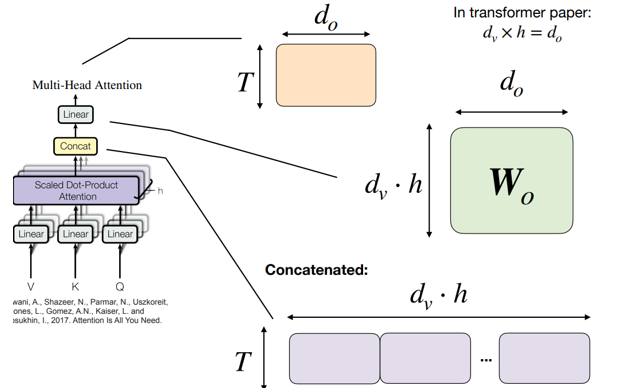

In [15]:
multi_A = torch.cat(A,dim=1)

In [16]:
wo = nn.Linear(int(dv*h),do,bias = False)
wo.weight.shape

torch.Size([512, 512])

In [17]:
encoder_output = wo(multi_A)


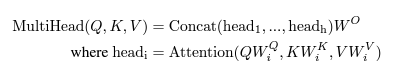
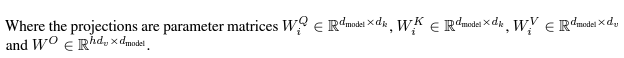

In [18]:
def multi_head(d_model,dv,dk,h,data)->"T x do":
    """
    do = d_v *h
    wo : do x do 
    """
    A = []
    for i in range(h):
        head = self_attention(d_model,dv, dk,data)
        A.append(head)
    multi_A = torch.cat(A,dim=1)
    wo = nn.Linear(int(dv*h),int(dv*h),bias = False)
    encoder_output = wo(multi_A)
    return encoder_output

In [19]:
output = multi_head(d_model,dv,dk,h,data)
output.shape

torch.Size([100, 512])

In [20]:
# transformer에서 d_e는 d_model과 같음을 잊지 말자
output.shape == data.shape , output.shape

(True, torch.Size([100, 512]))

Second Layer FFN
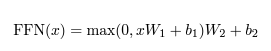

$W_1 \in \mathbb{R}^{d_{model}\; \times d_{ff}}$  
$W_2 \in \mathbb{R}^{d_{ff}\; \times d_{model}}$

In [44]:
class Pointwise(nn.Module):
    def __init__(self,d_model=512,dff=2048):
        super().__init__()
        self.ffn = nn.Sequential(nn.Linear(d_model,dff),
                                 nn.ReLU(),
                                 nn.Linear(dff,d_model))
    def forward(self,x):
        return self.ffn(x)
    
class SelfAttention(nn.Module):
    def __init__(self,d_model,dv, dk):
        super().__init__()
        self.wq = nn.Linear(d_model,dk,bias = False)
        self.wk = nn.Linear(d_model,dk,bias = False)
        self.wv = nn.Linear(d_model,dv,bias = False)
        self.softmax = nn.Softmax(dim=1)#batch가 존재할 경우 다음을 사용 
    def forward(self,x):
        Q = self.wq(x)
        K = self.wk(x)
        V = self.wv(x)
        sqrt_dk = torch.sqrt(torch.tensor(dk,dtype = torch.float32)) 
        score = Q@K.T
        scaling = score/sqrt_dk
        # distribution = self.softmax(scaling) when you use batch_size
        distribution = nn.Softmax(dim=0)(scaling) # Softmax는 T를 기준으로 해야함
        return distribution@V

class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,dv,dk,h):
        super().__init__()
        """
        do = d_v *h
        wo : do x do 
        """
        self.h = h
        self.attention = SelfAttention(d_model,dv, dk)
        self.wo = nn.Linear(int(dv*h),int(dv*h),bias = False) #dv*h  x  d_o

    def forward(self,x)->"T x do":
        A = []
        for i in range(self.h):
            A.append(self.attention(x))
        multi_A = torch.cat(A,dim=1) # Not batch
        # multi_A = torch.cat(A,dim=2) # Use batch
        
        return self.wo(multi_A)

class Encoder(nn.Module):
    def __init__(self,d_model,dv,dk,dff,h,data):
        super().__init__()
        self.multi_head = MultiHeadAttention(d_model,dv,dk,h)
        self.layer_norm = nn.LayerNorm(d_model)
        self.ffn = Pointwise(d_model,dff)
    def forward(self,x):
        #x: positional encoding matrix
        output   = self.multi_head(x)
        x = x+output #residual connection
        x= self.layer_norm(x)
        
        output_2 = self.multi_head(x)
        x = output_2+x
        encoder_output = self.layer_norm(x)
        return encoder_output

In [ ]:
class Transformer_Encoder(nn.Module)